In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix


In [11]:
# Set up paths
data_dir = 'merged_cropped_dataset'
img_height, img_width = 150, 150
batch_size = 32

# Create training, validation, and test sets using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=False
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)



Found 75000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.


In [12]:
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam

# Load InceptionV3 with pre-trained ImageNet weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_46 (BatchN  (None, 74, 74, 32)  96          ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [13]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
2344/2344 [==============================] - 3068s 1s/step - loss: 0.4518 - accuracy: 0.7921 - val_loss: 0.4745 - val_accuracy: 0.7614
Epoch 2/5
2344/2344 [==============================] - 2047s 874ms/step - loss: 0.3526 - accuracy: 0.8446 - val_loss: 0.4479 - val_accuracy: 0.7782
Epoch 3/5
2344/2344 [==============================] - 1653s 705ms/step - loss: 0.3163 - accuracy: 0.8636 - val_loss: 0.4430 - val_accuracy: 0.7844
Epoch 4/5
2344/2344 [==============================] - 525s 224ms/step - loss: 0.2978 - accuracy: 0.8719 - val_loss: 0.4302 - val_accuracy: 0.7965
Epoch 5/5
2344/2344 [==============================] - 295s 126ms/step - loss: 0.2834 - accuracy: 0.8800 - val_loss: 0.4581 - val_accuracy: 0.7904


In [14]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


782/782 [==============================] - 71s 91ms/step - loss: 0.4581 - accuracy: 0.7904
Validation Accuracy: 79.04%


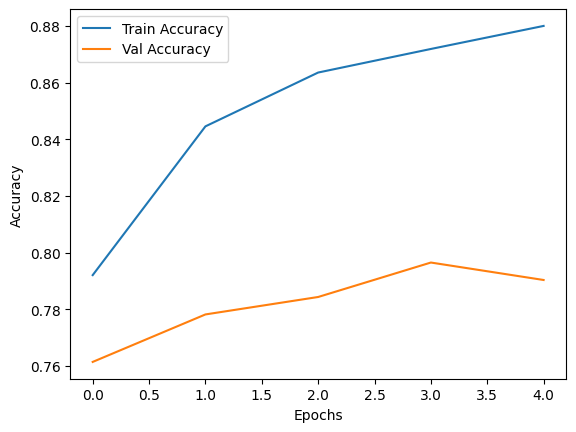

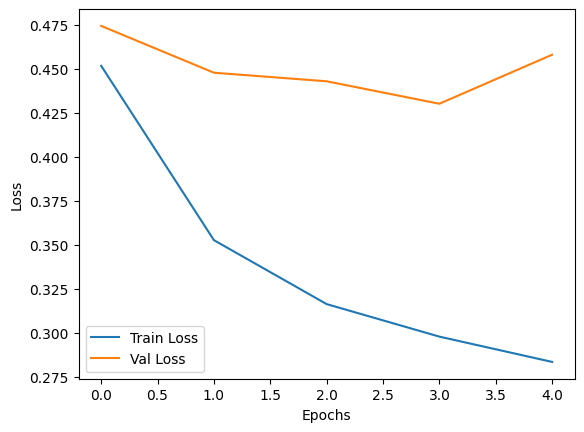

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Reset and predict
val_data.reset()
y_pred = model.predict(val_data, verbose=1)
y_pred = (y_pred > 0.5).astype(int)

# True labels
y_true = val_data.classes

# Evaluation
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['spoof', 'real']))


782/782 [==============================] - 61s 76ms/step
[[ 8459  4041]
 [ 1200 11300]]
              precision    recall  f1-score   support

       spoof       0.88      0.68      0.76     12500
        real       0.74      0.90      0.81     12500

    accuracy                           0.79     25000
   macro avg       0.81      0.79      0.79     25000
weighted avg       0.81      0.79      0.79     25000



In [17]:
# Save the trained model
model.save('spook_classifier_model.h5')
